In [14]:
import os
import logging
# Suppress TensorFlow and XLA logs
# Suppress TensorFlow warnings before compiling
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
os.environ['TF_CPP_MIN_LOG_LEVEL']= '3'  # Suppress TF warnings
os.environ['TF_XLA_FLAGS'] = '--tf_xla_auto_jit=0'  # Disable XLA auto-jit to reduce logs
logging.getLogger('absl').setLevel(logging.ERROR)
logging.getLogger('tensorflow').setLevel(logging.ERROR)  # Only show ERROR logs

In [24]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from sklearn.utils import class_weight
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model

In [7]:
# Load the training and testing CSV files
train_csv = pd.read_csv('/kaggle/input/fundus-data/training_data.csv')
test_csv = pd.read_csv('/kaggle/input/fundus-data/testing_data.csv')

In [8]:
# Extract labels
y_train = train_csv['diagnosis']
y_val = test_csv['diagnosis']

In [9]:
# Load preprocessed arrays
X_train_preprocessed = np.load('/kaggle/input/fundus-data/X_train_preprocessed.npy')
X_val_preprocessed = np.load('/kaggle/input/fundus-data/X_val_preprocessed.npy')

In [10]:
# Verify shapes
print(f"Training data shape: {X_train_preprocessed.shape}")
print(f"Validation data shape: {X_val_preprocessed.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation labels shape: {y_val.shape}")

Training data shape: (3295, 224, 224, 3)
Validation data shape: (367, 224, 224, 3)
Training labels shape: (3295,)
Validation labels shape: (367,)


## Model training 

In [15]:
# Callbacks
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.3, patience=4, min_lr=1e-7, mode='max')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True, mode='max')

# Load DenseNet121 without the top classification layer
densenet_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Unfreeze slightly more top layers of DenseNet while keeping the bottom frozen
for layer in densenet_model.layers[-30:]:
    layer.trainable = True

# Create a Sequential model with the DenseNet base
densenet_hybrid_model = Sequential([
    densenet_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.7),  # Slightly increased dropout to reduce overfitting
    Dense(5, activation='softmax')  # Output layer for classification
])

# Compile the model with a slightly lower learning rate
optimizer = Adam(learning_rate=1e-4)  # Reduced learning rate for finer adjustments
densenet_hybrid_model.compile(optimizer=optimizer,
                              loss='sparse_categorical_crossentropy',
                              metrics=['accuracy'])

# Train the model
history_densenet = densenet_hybrid_model.fit(
    X_train_preprocessed, y_train,
    validation_data=(X_val_preprocessed, y_val),
    epochs=10, 
    batch_size=32,
    callbacks=[reduce_lr, early_stopping]
)


Epoch 1/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 305s 1s/step - accuracy: 0.5578 - loss: 1.2395 - val_accuracy: 0.6839 - val_loss: 0.9714 - learning_rate: 1.0000e-04
Epoch 2/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.7692 - loss: 0.5881 - val_accuracy: 0.7575 - val_loss: 0.7111 - learning_rate: 1.0000e-04
Epoch 3/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 169ms/step - accuracy: 0.8248 - loss: 0.4659 - val_accuracy: 0.8147 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 4/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 18s 170ms/step - accuracy: 0.8538 - loss: 0.4066 - val_accuracy: 0.8283 - val_loss: 0.4790 - learning_rate: 1.0000e-04
Epoch 5/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9006 - loss: 0.2728 - val_accuracy: 0.8283 - val_loss: 0.5589 - learning_rate: 1.0000e-04
Epoch 6/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 167ms/step - accuracy: 0.9339 - loss: 0.2041 - val_accuracy: 0.7929 - val_loss: 0.6608 - learning_rate: 1.0000e-04
Epoch 7/10
103/103 ━━━━━━━━━━━━━━━━━━━━ 17s 168m

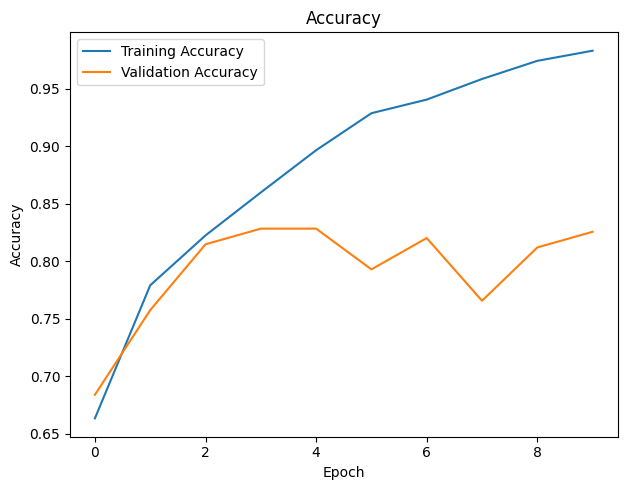

In [30]:
# Plotting training and validation accuracy and loss
plt.figure(figsize=(12, 5))

# Plotting training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Training Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [20]:
# Evaluation on validation set
y_val_pred_probs = densenet_hybrid_model.predict(X_val_preprocessed)
y_val_preds = np.argmax(y_val_pred_probs, axis=1)

print("\nClassification Report on Validation Set:\n")
print(classification_report(y_val, y_val_preds))

val_accuracy = accuracy_score(y_val, y_val_preds)
val_precision = precision_score(y_val, y_val_preds, average='macro')
val_recall = recall_score(y_val, y_val_preds, average='macro')
val_f1 = f1_score(y_val, y_val_preds, average='macro')

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision (Macro): {val_precision:.4f}")
print(f"Validation Recall (Macro): {val_recall:.4f}")
print(f"Validation F1 Score (Macro): {val_f1:.4f}")


12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 1s/step

Classification Report on Validation Set:

              precision    recall  f1-score   support

           0       0.95      0.98      0.97       181
           1       0.63      0.59      0.61        37
           2       0.73      0.85      0.79       100
           3       0.53      0.42      0.47        19
           4       0.79      0.37      0.50        30

    accuracy                           0.83       367
   macro avg       0.73      0.64      0.67       367
weighted avg       0.82      0.83      0.82       367

Validation Accuracy: 0.8283
Validation Precision (Macro): 0.7264
Validation Recall (Macro): 0.6431
Validation F1 Score (Macro): 0.6672


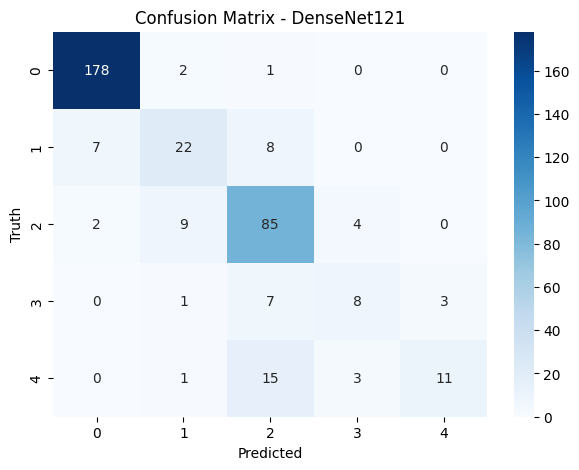

In [23]:
# Display confusion matrix
cm = confusion_matrix(y_val, y_val_preds)
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Confusion Matrix - DenseNet121')
plt.show()

In [27]:
# Save Model
densenet_hybrid_model.save('/kaggle/working/densenet_fundus_clahe_final.h5')
print("Model saved to /kaggle/working/densenet_fundus_clahe_final.h5")

Model saved to /kaggle/working/densenet_fundus_clahe_final.h5


In [28]:
!ls -lh /kaggle/working/densenet_fundus_clahe_final.h5

-rw-r--r-- 1 root root 85M May  2 13:54 /kaggle/working/densenet_fundus_clahe_final.h5


In [29]:
from IPython.display import FileLink
FileLink('/kaggle/working/densenet_fundus_clahe_final.h5')

/kaggle/working/densenet_fundus_clahe_final.h5